In [1]:
from sklearn.datasets import load_files   
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(data_path, shuffle=None):
    kwargs = {}
    if shuffle != None:
        kwargs['shuffle'] = shuffle
    data = load_files(data_path, **kwargs)
    img_files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, targets

train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test', shuffle=False)

# load lables
label_name = [item[11:-1] for item in sorted(glob("data/train/*/"))]

Using TensorFlow backend.


In [2]:
print('train_files size: {}'.format(len(train_files)))
print('train_files shape: {}'.format(train_files.shape))
print('target shape: {}'.format(train_targets.shape))
print(label_name)

train_files size: 2000
train_files shape: (2000,)
target shape: (2000, 3)
['melanoma', 'nevus', 'seborrheic_keratosis']


In [3]:
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from tqdm import tqdm


def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(384, 256))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(image_paths):
    return np.vstack([path_to_tensor(path) for path in image_paths])

In [4]:
train_tensors = paths_to_tensor(tqdm(train_files))
valid_tensors = paths_to_tensor(tqdm(valid_files))
test_tensors = paths_to_tensor(tqdm(test_files))

print(train_tensors.shape)

100%|██████████| 600/600 [08:08<00:00,  4.62it/s]


(2000, 384, 256, 3)


In [5]:
# train_imgs_preprocess is created below
train_imgs_preprocess = preprocess_input(train_tensors)
valid_imgs_preprocess = preprocess_input(valid_tensors)
test_imgs_preprocess = preprocess_input(test_tensors)
del train_tensors, valid_tensors, test_tensors

In [6]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
transfer_model = InceptionResNetV2(include_top=False)

train_data = transfer_model.predict(train_imgs_preprocess)
valid_data = transfer_model.predict(valid_imgs_preprocess)
test_data = transfer_model.predict(test_imgs_preprocess)

del train_imgs_preprocess, valid_imgs_preprocess, test_imgs_preprocess
print(train_data.shape)

(2000, 10, 6, 1536)


In [9]:
import gc
gc.collect()

0

In [11]:
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential

my_model = Sequential()
# my_model = Sequential(inputs=transfer_model.input, outputs=transfer_model.get_layer('avg_pool').output)
my_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
my_model.add(Dropout(0.2))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.2))

my_model.add(Dense(3, activation='softmax'))
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 1,576,963
Trainable params: 1,576,963
Non-trainable params: 0
_________________________________________________________________


In [12]:
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint


checkpoint_filepath = 'weights.best.my.hdf5'

my_checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,
                               verbose=1, save_best_only=True)

my_model.fit(train_data, train_targets, 
          validation_data=(valid_data, valid_targets),
          epochs=60, batch_size=200, callbacks=[my_checkpointer], verbose=1)

Train on 2000 samples, validate on 150 samples
Epoch 1/60
2000/2000 [==============================] - 4s 2ms/step - loss: 1.5470 - acc: 0.5340 - val_loss: 1.5347 - val_acc: 0.5200

Epoch 00001: val_loss improved from inf to 1.53471, saving model to weights.best.my.hdf5
Epoch 2/60
2000/2000 [==============================] - 1s 447us/step - loss: 0.8302 - acc: 0.6615 - val_loss: 1.0035 - val_acc: 0.5200

Epoch 00002: val_loss improved from 1.53471 to 1.00346, saving model to weights.best.my.hdf5
Epoch 3/60
2000/2000 [==============================] - 1s 447us/step - loss: 0.7474 - acc: 0.6970 - val_loss: 0.8463 - val_acc: 0.6133

Epoch 00003: val_loss improved from 1.00346 to 0.84632, saving model to weights.best.my.hdf5
Epoch 4/60
2000/2000 [==============================] - 1s 447us/step - loss: 0.6850 - acc: 0.7100 - val_loss: 0.8857 - val_acc: 0.5733

Epoch 00004: val_loss did not improve from 0.84632
Epoch 5/60
2000/2000 [==============================] - 1s 447us/step - loss: 0.6

In [14]:
my_model.save('my_model.h5')
# transfer_model.save('transfer_model.h5')
my_model.load_weights(checkpoint_filepath)

In [15]:
import csv


my_predictions = [my_model.predict(np.expand_dims(feature, axis=0)) for feature in test_data]

# test_accuracy = 100 * np.sum(np.array(my_predictions)==np.argmax(test_targets, axis=1)) / len(my_predictions)
# print('Test accuracy: %.4f%%' % test_accuracy)

with open('my_transfer.csv', 'w', newline='') as csvfile:
    result_writger = csv.writer(csvfile)
    result_writger.writerow(['Id', 'task_1', 'task_2'])
    for test_filepath, test_prediction in zip(test_files, my_predictions):
        result_writger.writerow([test_filepath, test_prediction[0][0], test_prediction[0][2]])

In [16]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from sklearn.metrics import roc_curve, auc, confusion_matrix

In [17]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

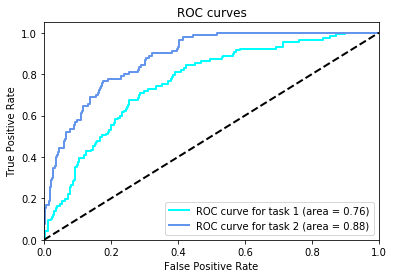

Category 1 Score: 0.762
Category 2 Score: 0.878
Category 3 Score: 0.820


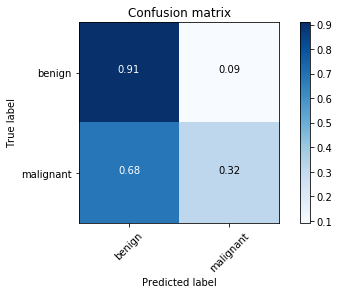

In [18]:
thresh = 0.5
preds_path ='my_transfer.csv'
# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv(preds_path)
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)